In [1]:
import plumed
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import networkx as nx
import nglview as nv
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (12, 8)
import pandas as pd
def slice(traj, selection):
    return traj.atom_slice(traj.top.select(selection))

1shg_PTPP 134941 0.7289677 -7.380922622182593 1.7447493
1shg_PCGP 128041 0.3647852 -2.451597730498488 1.6178226
1shg_PEGP 121721 0.3799041 -11.877800167625777 1.5209726
1shg_YPH 0.776721 unfinished
1shg_PKWP 138941 0.73227054 -6.033695023258529 1.1450382
1shg_PYGP 123161 0.36835808 -3.473676754115255 1.6458622
1shg_PKRP 140141 0.73120815 -10.540287198991075 1.8244427
1shg_PLWP 118721 0.72794926 -1.5976303069356967 1.575756
1shg_RHW 200371 0.7067338 -4.003712199845558 1.047745
1shg_PGGP 125661 0.3663687 -4.629727140608384 1.7456597
1shg_PPWP 128921 0.3738229 -5.050457294947502 1.4637783
1shg_PRWP 145401 0.7237473 -4.196538170809428 1.0213184
1shg_HPY 200288 0.73274374 -3.0415702478255016 1.0469232
1shg_PKKP 139461 0.7323067 -6.104887699532193 0.6727283
1shg_HYD 200265 0.7138444 -10.517673512216271 1.1998028
1shg_RYD 200344 0.70199704 -7.16011293640953 1.9542625
1shg_PLPP 138501 0.72133136 -2.7667941309683046 0.6262552
1shg_KHW 201059 0.706068 -7.786723690521497 0.50565416
1shg_PDPP 0.72

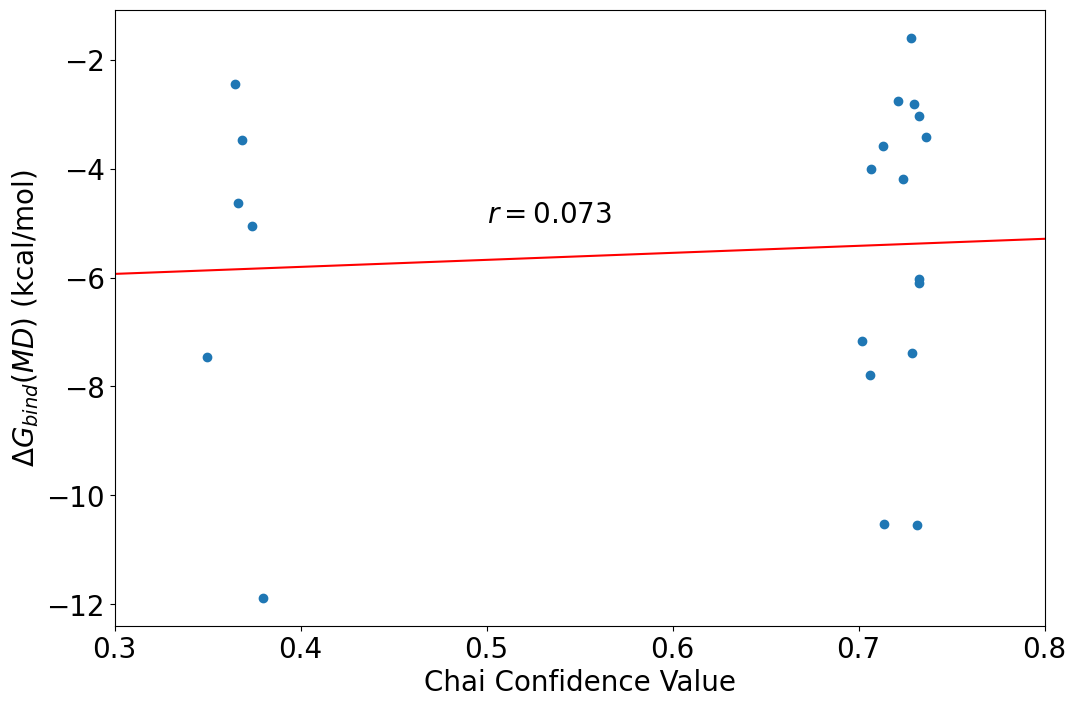

In [13]:
from scipy import stats
import warnings
from adjustText import adjust_text as adjust_text_func

warnings.filterwarnings('ignore')
# names = confs['Name'].to_numpy()
# conf_vals = confs['Confidence'].to_numpy()
dgs = []
true_confs = []
old_confs = []
texts = []
rmsds = []
ktkc = 0.5915
kT = 2.479
dg_vals = pd.DataFrame(columns=['Sequence', 'dG'])
fig, ax = plt.subplots()

    
for i, plb in enumerate(os.listdir(os.getcwd())):
    try:
        traj = md.load(os.path.join(plb, '3_funnel', 'md_whole.xtc'), top=os.path.join(plb, '3_funnel', 'md_whole.gro'))
        colvar_path = os.path.join(plb, "3_funnel/colvar_reweight.dat")
        colvar = plumed.read_as_pandas(colvar_path) 
        d1 = colvar['d1'].to_numpy()
        rmsd = colvar['rmsd'].to_numpy()
        lp = colvar['fps.lp'].to_numpy()
        ld = colvar['fps.ld'].to_numpy()
        bias = colvar['metad.bias'].to_numpy()
        bias_weights = np.exp(bias / kT) 
        total = sum(bias_weights)
        bias_weights /= total
        hist, bins = np.histogram(lp, bins=50, weights=bias_weights)
        potential = -ktkc * np.log(hist)
        bins = bins[:-1]
        dg = np.min(potential[bins < 0.5]) - np.min(potential[bins > 1.0]) 
        chai_conf = np.load(f'../chai_results/{plb}/aggregate.npy')[0]
        for k in range(5):
            tt = slice(md.load( f'../chai_results/{plb}/pred.model_trunk_0_idx_{k}.pdb'), 'chainid 1')
            if k == 0:
                traj = tt
            else:
                traj = traj.join(tt)
        # print(slice(md.load(f'../ligands/{plb[5:]}.pdb'), 'not element H').topology)
        traj.topology = slice(md.load(f'../ligands/{plb[5:]}.pdb'), 'not element H').topology
        # print(np.sin(md.compute_psi(traj)[1]))
        rmsd = np.linalg.norm(np.std(np.sin(md.compute_phi(traj)[1]), axis=0) + np.std(np.sin(md.compute_psi(traj)[1]), axis=0))
        # print(len(colvar['time']))
        if len(colvar['time']) > 70000:
            # print(rmsd)
            true_confs.append(chai_conf)
            # t = ax.text(chai_conf - .03, dg, plb[5:], fontsize=12)
            # texts.append(t)
            dgs.append(dg)
            rmsds.append(rmsd)
            dg_vals = pd.concat([pd.DataFrame([[plb[5:],dg]], columns=dg_vals.columns), dg_vals], ignore_index=True)
            print(plb, len(colvar['time']), chai_conf, dg, np.linalg.norm(rmsds[-1]))
        else:
            print(plb, chai_conf, 'unfinished')
    except:
        continue
true_confs = np.array(true_confs)
# for text in adjusted_texts[0]:
#     plt.text(text.x, text.y, text.text, ha="center", va="center")
dg_vals.to_csv('dg.csv')
slope, intercept, r_value, p_value, std_err = stats.linregress(true_confs, dgs)
ends = np.array([0.2, 0.9])
ax.plot(ends, float(slope) * np.array(ends) + intercept, color='red')
ax.text(0.5, -5, f"$r = {round(r_value, 3)}$")
ax.set_xlim([0.3, 0.8])
ax.set_xlabel("Chai Confidence Value")
ax.set_ylabel("$\Delta G_{bind}(MD)$ (kcal/mol)")
ax.scatter(true_confs, dgs)
# adjust_text_func(texts, x=np.repeat(true_confs, 2), y=np.concatenate((float(slope) * np.array(true_confs) + intercept, dgs)), ax=ax, max_move=[0.3, 0.3])



plt.show()

1shg_PTPP 134941 -7.380922622182593
old3/1shg_PTPP 200001 -6.710532655937548
1shg_PCGP 128041 -2.451597730498488
old3/1shg_PCGP 122701 -3.857806744592491
1shg_PEGP 121721 -11.877800167625777
old3/1shg_PEGP 128741 -2.3901321329660505
1shg_AAA_t 112521 -8.913056692423668
old3/1shg_YPH_2 345522 -4.981359792546714
1shg_PKWP 138941 -6.033695023258529
old3/1shg_PKWP 123081 -8.782994959569223
1shg_PYGP 123161 -3.473676754115255
old3/1shg_PKRP 200001 -10.515453641190236
1shg_PLWP 118721 -1.5976303069356967
old3/1shg_PLWP 333562 -7.4355399377580955
1shg_RHW 200371 -4.003712199845558
old3/1shg_RHW_2 343462 -10.788957499151774
1shg_PGGP 125661 -4.629727140608384
old3/1shg_PGGP 118201 -3.6232076332551086
1shg_PPWP 128921 -5.050457294947502
old3/1shg_PPWP 0.34978694 unfinished
1shg_PRWP 145401 -4.196538170809428
old3/1shg_PRWP 200001 -5.251228772286785
1shg_HPY 200288 -3.0415702478255016
old3/1shg_HPY_2 370762 -3.549154972358716
1shg_PKKP 139461 -6.104887699532193
old3/1shg_PKKP 126301 -7.632117848

ValueError: x and y must be the same size

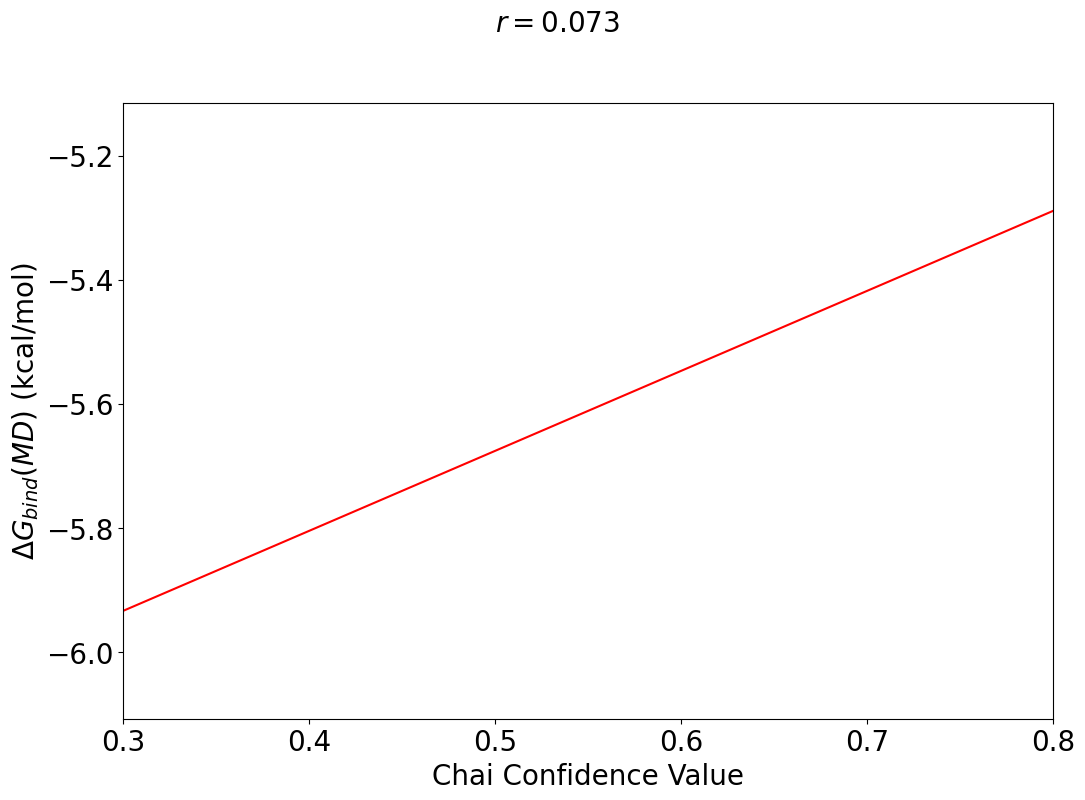

In [36]:
from scipy import stats
import warnings
from adjustText import adjust_text as adjust_text_func

warnings.filterwarnings('ignore')
# names = confs['Name'].to_numpy()
# conf_vals = confs['Confidence'].to_numpy()
new_dgs = []
old_dgs = []
true_confs = []
old_confs = []
texts = []
rmsds = []
ktkc = 0.5915
kT = 2.479
dg_vals = pd.DataFrame(columns=['Sequence', 'dG'])
fig, ax = plt.subplots()
ligs = []
    
for i, plb in enumerate(os.listdir(os.getcwd())):
    oplb = os.path.join('old3', plb)
    if len(oplb) < len('old3/1shg_PPPP'):
        oplb += '_2'
    for path, conf_list, dg_list in zip([plb, oplb], [true_confs, old_confs], [new_dgs, old_dgs]):
        if (len(new_dgs) == len(old_dgs) and 'old' not in path) or (len(new_dgs) == len(old_dgs) + 1 and 'old' in path):
            try:
                traj = md.load(os.path.join(path, '3_funnel', 'md_whole.xtc'), top=os.path.join(path, '3_funnel', 'md_whole.gro'))
                colvar_path = os.path.join(path, "3_funnel/colvar_reweight.dat")
                colvar = plumed.read_as_pandas(colvar_path) 
                d1 = colvar['d1'].to_numpy()
                rmsd = colvar['rmsd'].to_numpy()
                lp = colvar['fps.lp'].to_numpy()
                ld = colvar['fps.ld'].to_numpy()
                bias = colvar['metad.bias'].to_numpy()
                bias_weights = np.exp(bias / kT) 
                total = sum(bias_weights)
                bias_weights /= total
                hist, bins = np.histogram(lp, bins=50, weights=bias_weights)
                potential = -ktkc * np.log(hist)
                bins = bins[:-1]
                dg = np.min(potential[bins < 0.5]) - np.min(potential[bins > 1.0]) 
                if len(colvar['time']) > 70000:
                    dg_list.append(dg)
                    print(path, len(colvar['time']), dg)
                    if 'old' in path:
                        ligs.append(plb[5:])
                else:
                    if 'old' in path:
                        new_dgs.pop()
                    print(path, chai_conf, 'unfinished')
            except:
                continue
true_confs = np.array(true_confs)
# slope, intercept, r_value, p_value, std_err = stats.linregress(true_confs, dgs)
ends = np.array([0.2, 0.9])
ax.plot(ends, float(slope) * np.array(ends) + intercept, color='red')
ax.text(0.5, -5, f"$r = {round(r_value, 3)}$")
ax.set_xlim([0.3, 0.8])
ax.set_xlabel("Chai Confidence Value")
ax.set_ylabel("$\Delta G_{bind}(MD)$ (kcal/mol)")
ax.scatter(true_confs, dgs)
# adjust_text_func(texts, x=np.repeat(true_confs, 2), y=np.concatenate((float(slope) * np.array(true_confs) + intercept, dgs)), ax=ax, max_move=[0.3, 0.3])



plt.show()

ValueError: x and y must be the same size

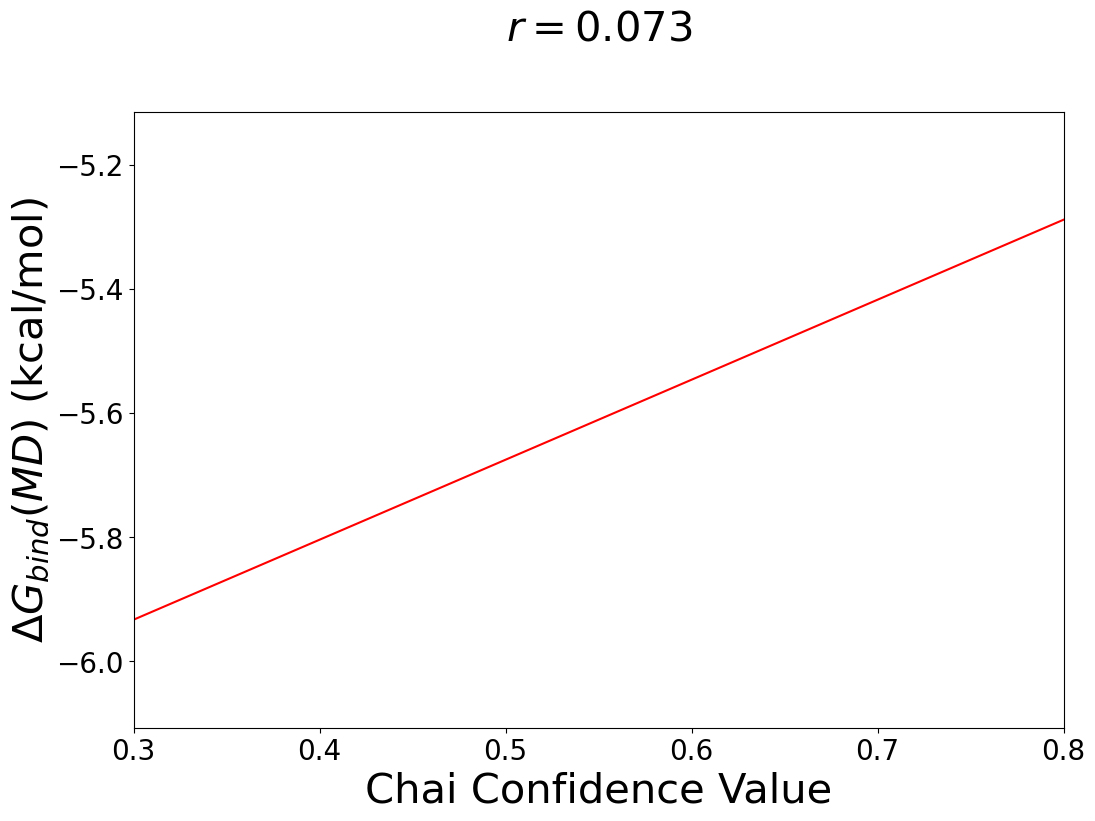

In [23]:
fig, ax = plt.subplots()

ax.plot(ends, float(slope) * np.array(ends) + intercept, color='red')
ax.text(0.5, -5, f"$r = {round(r_value, 3)}$", fontsize=30)
ax.set_xlim([0.3, 0.8])
ax.set_xlabel("Chai Confidence Value", fontsize=30)
ax.set_ylabel("$\Delta G_{bind}(MD)$ (kcal/mol)", fontsize=30)
ax.scatter(true_confs, dgs, s=55)
# adjust_text_func(texts, x=np.repeat(true_confs, 2), y=np.concatenate((float(slope) * np.array(true_confs) + intercept, dgs)), ax=ax, max_move=[0.3, 0.3])



plt.show()

In [4]:
names = confs['Name'].to_numpy()
conf_vals = confs['Confidence'].to_numpy()
import matplotlib.cm as cm
prot = md.load('../proteins/1shg.pdb')

def map_number_to_color(number, colormap='jet'):
    """Maps a number in the range [0, 1) to a color based on a colormap.
    
    Args:
    number: A float in the range [0, 1).
    colormap: The name of the colormap to use.
    
    Returns:
    A tuple of (red, green, blue, alpha) representing the color.
    """
    
    cmap = cm.get_cmap(colormap)
    rgba = cmap(number)
    rgb_string = f"{int(rgba[0] * 255):02X}{int(rgba[1] * 255):02X}{int(rgba[2] * 255):02X}"
    return int(rgb_string, 16)

def make_color(a, v):
    width = np.max(v) - np.min(v)
    mapped = (a - np.min(v)) / (width * 1.01)
    return map_number_to_color(mapped)
views = []
colors = [
    "red", "blue", "green", "yellow", "orange",
    "purple", "pink", "brown", "gray", "black",
    "white", "silver", "gold", "lime", "cyan",
    "magenta", "indigo", "teal", "navy", "maroon",
    "olive", "chartreuse", "aquamarine", "coral", "crimson",
    "darkblue", "darkgreen", "darkred", "darkslateblue", "darkslategray",
    "darkturquoise", "deeppink", "dodgerblue", "firebrick", "forestgreen",
    "fuchsia", "gainsboro", "ghostwhite", "goldenrod", "greenyellow",
    "honeydew", "hotpink", "indianred", "ivory", "lavender",
    "lawngreen", "lemonchiffon", "lightblue", "lightcoral", "lightgreen",
    "lightgray", "lightskyblue", "lightslategray", "lightyellow", "linen"
]

v2 = nv.NGLWidget()
for i, plb in enumerate(confs['Name']):
    try:
        traj = md.load(os.path.join(plb, '3_funnel', 'md_whole.xtc'), top=os.path.join(plb, '3_funnel', 'md_whole.gro'))
        traj.superpose(prot, atom_indices=traj.top.select('protein and resSeq >= 6 and not element H'), ref_atom_indices=prot.top.select('protein and resSeq >= 6 and not element H'))
        view = nv.NGLWidget()
        view.add_trajectory(slice(traj[0], 'protein and resSeq >= 6'))
        if i == 0:
            v2.add_trajectory(slice(traj[0], 'protein and resSeq >= 6'))
        a = view.add_trajectory(slice(traj[0], 'protein and resSeq < 6'))
        a.clear_representations()
        a.add_representation('ball+stick', color='residueIndex')
        a = v2.add_trajectory(slice(traj[0], 'protein and resSeq < 6'))
        a.clear_representations()
        a.add_representation('ball+stick', color=make_color(dgs[i], dgs))
        views.append(view)
    except:
        pass

v2

NameError: name 'confs' is not defined

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

v2 = nv.NGLWidget()
prot = md.load('../proteins/1shg.pdb')
lst = 'GNQLPATS'
n = len(lst)
# plt.scatter(prot.xyz[0, :, 0], prot.xyz[0, :, 1], color='green', label='protein')
for i, p in enumerate(lst[:1]):
    plb = f'1shg_PP{p}P'
    ref_lig = md.load(os.path.join('../diffdock_results', plb, 'complex_0/ref_lig.pdb'))
    for j in range(1, 10):
        lig = md.load(os.path.join('../diffdock_results', plb, f'complex_0/rank{j}_reverseprocess.pdb'))
        non_h_indices = ref_lig.top.select("not element H")
        table, bonds = lig.top.to_dataframe()
        table2, bonds2 = ref_lig.atom_slice(non_h_indices).top.to_dataframe()
        table[['name', 'resSeq']] = table2[['name', 'resSeq']]
        table['name'].iloc[-1] = 'CA'
        table['resName'] = 'UNL'
        table['chainID'] = 0
        lig.topology = md.Topology.from_dataframe(table, bonds)
        # print(md.compute_phi(lig))
        # plt.scatter(md.compute_phi(lig)[1][0, 0], label=f'rank {j}')
        # plt.plot(md.compute_dihedrals(lig, [[4, 7, 9, 10]]))
        # if j == 1:
        #     plt.scatter(lig.xyz[1, 0, 0], lig.xyz[1, 0, 1], color=[i/(n+.1), 0, (n-i)/(n+.1)], label=p)
        # plt.show()

        if i == 0 and j < 2:
            plt.plot(np.sin(md.compute_phi(lig)[1][:, 0]), np.sin(md.compute_psi(lig)[1][:, 0]), c='red', label='residue 1')
            plt.plot(np.sin(md.compute_phi(lig)[1][:, 1]), np.sin(md.compute_psi(lig)[1][:, 1]), c='blue', label='residue 2')
            plt.plot(np.sin(md.compute_phi(lig)[1][:, 2]), np.sin(md.compute_psi(lig)[1][:, 2]), c='green', label='residue 3')
            plt.plot(np.sin(md.compute_phi(lig)[1][:, 3]), np.sin(md.compute_psi(lig)[1][:, 3]), c='purple', label='residue 4')
        else:
            plt.scatter(md.compute_phi(lig)[1][-1, 0], md.compute_psi(lig)[1][-1, 0], c='red')
            plt.scatter(md.compute_phi(lig)[1][-1, 1], md.compute_psi(lig)[1][-1, 1], c='blue')
            plt.scatter(md.compute_phi(lig)[1][-1, 2], md.compute_psi(lig)[1][-1, 2], c='green')
            plt.scatter(md.compute_phi(lig)[1][-1, 3], md.compute_psi(lig)[1][-1, 3], c='purple')
    # if i == 0:
    #     v2.add_trajectory(prot)
    # # a = view.add_trajectory(lig)
    # # a.clear_representations()
    # # a.add_representation('ball+stick', color='residueIndex')
    # a = v2.add_trajectory(lig)
    # a.clear_representations()
    # a.add_representation('ball+stick', color=make_color(dgs[i], dgs))

    # views.append(view)
plt.title('Diffdock protein and ligand starting locations')
plt.xlabel('$x$')
plt.ylabel('$y$')
# plt.xlim([-2, 3])
plt.legend()
plt.show()

here
1shg_HYD/3_funnel 150000 0.7138444 -8.029502402852941
here
test_05kj_ellipsoid 150000 0.7138444 -2.8644449211927965
here
test_ellipsoid 150000 0.7138444 -2.8941942214009733
here
test_05kj 150000 0.7138444 -4.50316685408194


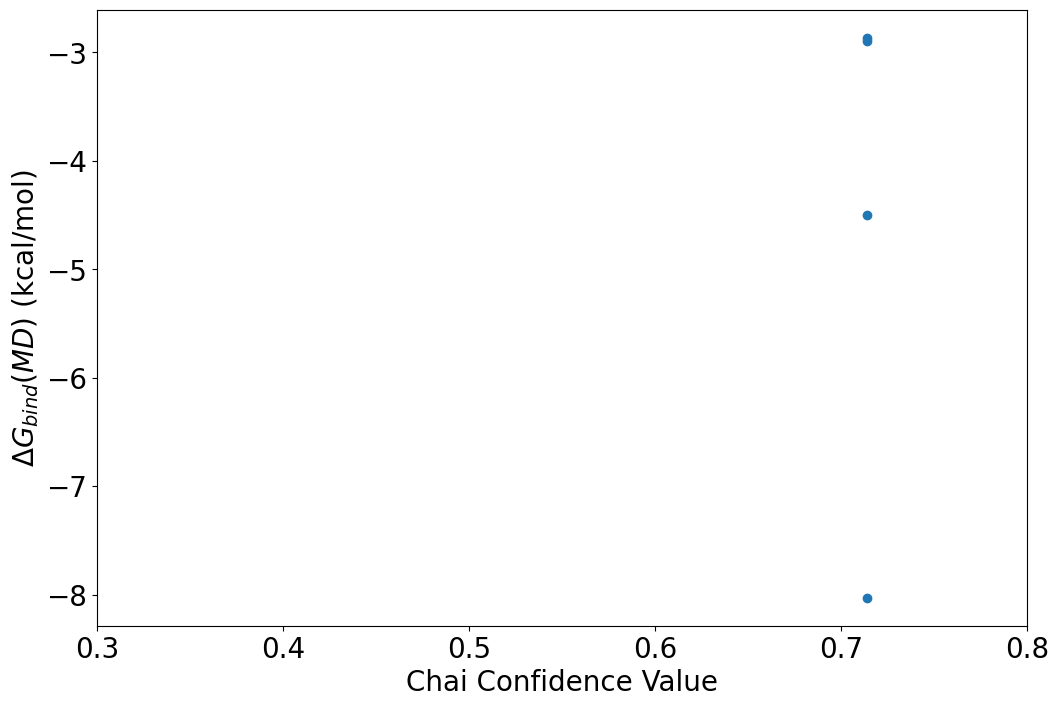

In [24]:
from scipy import stats
import warnings
from adjustText import adjust_text as adjust_text_func
import json
warnings.filterwarnings('ignore')
# names = confs['Name'].to_numpy()
# conf_vals = confs['Confidence'].to_numpy()
dgs = []
true_confs = []
old_confs = []
texts = []
rmsds = []
ktkc = 0.5915
kT = 2.479
dg_vals = pd.DataFrame(columns=['Sequence', 'dG'])
fig, ax = plt.subplots()

    
for i, plb in enumerate(['1shg_HYD/3_funnel', 'test_05kj_ellipsoid', 'test_ellipsoid', 'test_05kj']):
    try:
        traj = md.load(os.path.join(plb, 'md_whole.xtc'), top=os.path.join(plb, 'md_whole.gro'))
        colvar_path = os.path.join(plb, "colvar_reweight.dat")
        colvar = plumed.read_as_pandas(colvar_path) 
        colvar = colvar[:150000]
        d1 = colvar['d1'].to_numpy()
        rmsd = colvar['rmsd'].to_numpy()
        lp = colvar['fps.lp'].to_numpy()
        ld = colvar['fps.ld'].to_numpy()
        bias = colvar['metad.bias'].to_numpy()
        bias_weights = np.exp(bias / kT) 
        total = sum(bias_weights)
        bias_weights /= total
        hist, bins = np.histogram(lp, bins=50, weights=bias_weights)
        print('here')
        params = json.load(open(f'{plb}/params.json', 'r'))
        bins = bins[:-1]

        if 'ellipsoid' not in plb:
            rcyl = float(params['rcyl'])
            alpha = float(params['alpha'])
            cone_length = float(params['cone_length'])
            radius = np.maximum(rcyl * np.ones(len(bins)), rcyl + alpha * (cone_length - bins))
            potential = -ktkc * np.log(hist) + ktkc * np.log(np.pi * np.square(radius * 10) / 1660)

        else:
            inter_dist = float(params['interaction_dist'])
            rsq = inter_dist ** 2 * (1 - (bins ** 2) / 4)
            potential = -ktkc * np.log(hist) + ktkc * np.log(np.pi * rsq * 100 / 1660)
        dg = np.min(potential[bins < 0.5]) - np.min(potential[np.logical_and(bins > 0.5, bins < 1.2)]) 
        chai_conf = np.load(f'../chai_results/1shg_HYD/aggregate.npy')[0]
        for k in range(5):
            tt = slice(md.load( f'../chai_results/1shg_HYD/pred.model_trunk_0_idx_{k}.pdb'), 'chainid 1')
            if k == 0:
                traj = tt
            else:
                traj = traj.join(tt)
        # print(slice(md.load(f'../ligands/{plb[5:]}.pdb'), 'not element H').topology)
        traj.topology = slice(md.load(f'../ligands/HYD.pdb'), 'not element H').topology
        # print(np.sin(md.compute_psi(traj)[1]))
        # print(len(colvar['time']))
        if len(colvar['time']) > 70000:
            # print(rmsd)
            true_confs.append(chai_conf)
            # t = ax.text(chai_conf - .03, dg, plb[5:], fontsize=12)
            # texts.append(t)
            dgs.append(dg)
            print(plb, len(colvar['time']), chai_conf, dg)
        else:
            print(plb, chai_conf, 'unfinished')
    except:
        continue
true_confs = np.array(true_confs)
# for text in adjusted_texts[0]:
#     plt.text(text.x, text.y, text.text, ha="center", va="center")
# slope, intercept, r_value, p_value, std_err = stats.linregress(true_confs, dgs)
# ends = np.array([0.2, 0.9])
# ax.plot(ends, float(slope) * np.array(ends) + intercept, color='red')
# ax.text(0.5, -5, f"$r = {round(r_value, 3)}$")
ax.set_xlim([0.3, 0.8])
ax.set_xlabel("Chai Confidence Value")
ax.set_ylabel("$\Delta G_{bind}(MD)$ (kcal/mol)")
ax.scatter(true_confs, dgs)
# adjust_text_func(texts, x=np.repeat(true_confs, 2), y=np.concatenate((float(slope) * np.array(true_confs) + intercept, dgs)), ax=ax, max_move=[0.3, 0.3])



plt.show()